In [151]:

from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import time
from collections import deque
from IPython.core.display import display

SEQ_LEN=48

In [152]:
dataset_location = "/Users/i354746/private/magisterka/datasets/eurusd-m15-2018/EURUSD.csv"

df = pd.read_csv(dataset_location)

print(df.head())

Date Timestamp     Open     High      Low    Close       Volume
0  20150125  22:00:00  1.11521  1.11562  1.11378  1.11380   767.030002
1  20150125  22:15:00  1.11380  1.11447  1.11354  1.11422   775.439999
2  20150125  22:30:00  1.11426  1.11491  1.11413  1.11482   601.629998
3  20150125  22:45:00  1.11483  1.11485  1.11422  1.11430   629.209997
4  20150125  23:00:00  1.11438  1.11489  1.11397  1.11425  1674.320000


In [153]:
df.rename(columns={
    'Open': 'open', 'Close': 'close',
    'High': 'high', 'Low': 'low',
    'Close': 'close', 'Volume': 'volume',
    "Date": "date", 'Timestamp': 'timestamp', }, inplace=True)


df["timestamp"] = df["date"].astype(str) + " " + df["timestamp"]
df.drop("date", 1, inplace=True)
df.rename(columns={'Time': 'timestamp', 'Open': 'open', 'Close': 'close',
                   'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.fillna(method="ffill", inplace=True)
# df.plot.line(x="timestamp", y="close")


In [154]:
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).astype(int)
df["timestamp"] = df["timestamp"]/1000000000
df.set_index('timestamp', inplace=True)
df = df.astype(float)

# Add additional features
df['momentum'] = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high']) / 2
df['range'] = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close']) / 4
df['oc_diff'] = df['open'] - df['close']

display(df.head())

,open,high,low,close,volume,momentum,avg_price,range,ohlc_price,oc_diff
timestamp,,,,,,,,,,
1.422223e+09,1.11521,1.11562,1.11378,1.11380,767.030002,1.081512,1.114700,0.00184,1.114603,0.00141
1.422224e+09,1.11380,1.11447,1.11354,1.11422,775.439999,-0.325685,1.114005,0.00093,1.114008,-0.00042
1.422225e+09,1.11426,1.11491,1.11413,1.11482,601.629998,-0.336913,1.114520,0.00078,1.114530,-0.00056
1.422226e+09,1.11483,1.11485,1.11422,1.11430,629.209997,0.333481,1.114535,0.00063,1.114550,0.00053
1.422227e+09,1.11438,1.11489,1.11397,1.11425,1674.320000,0.217662,1.114430,0.00092,1.114372,0.00013


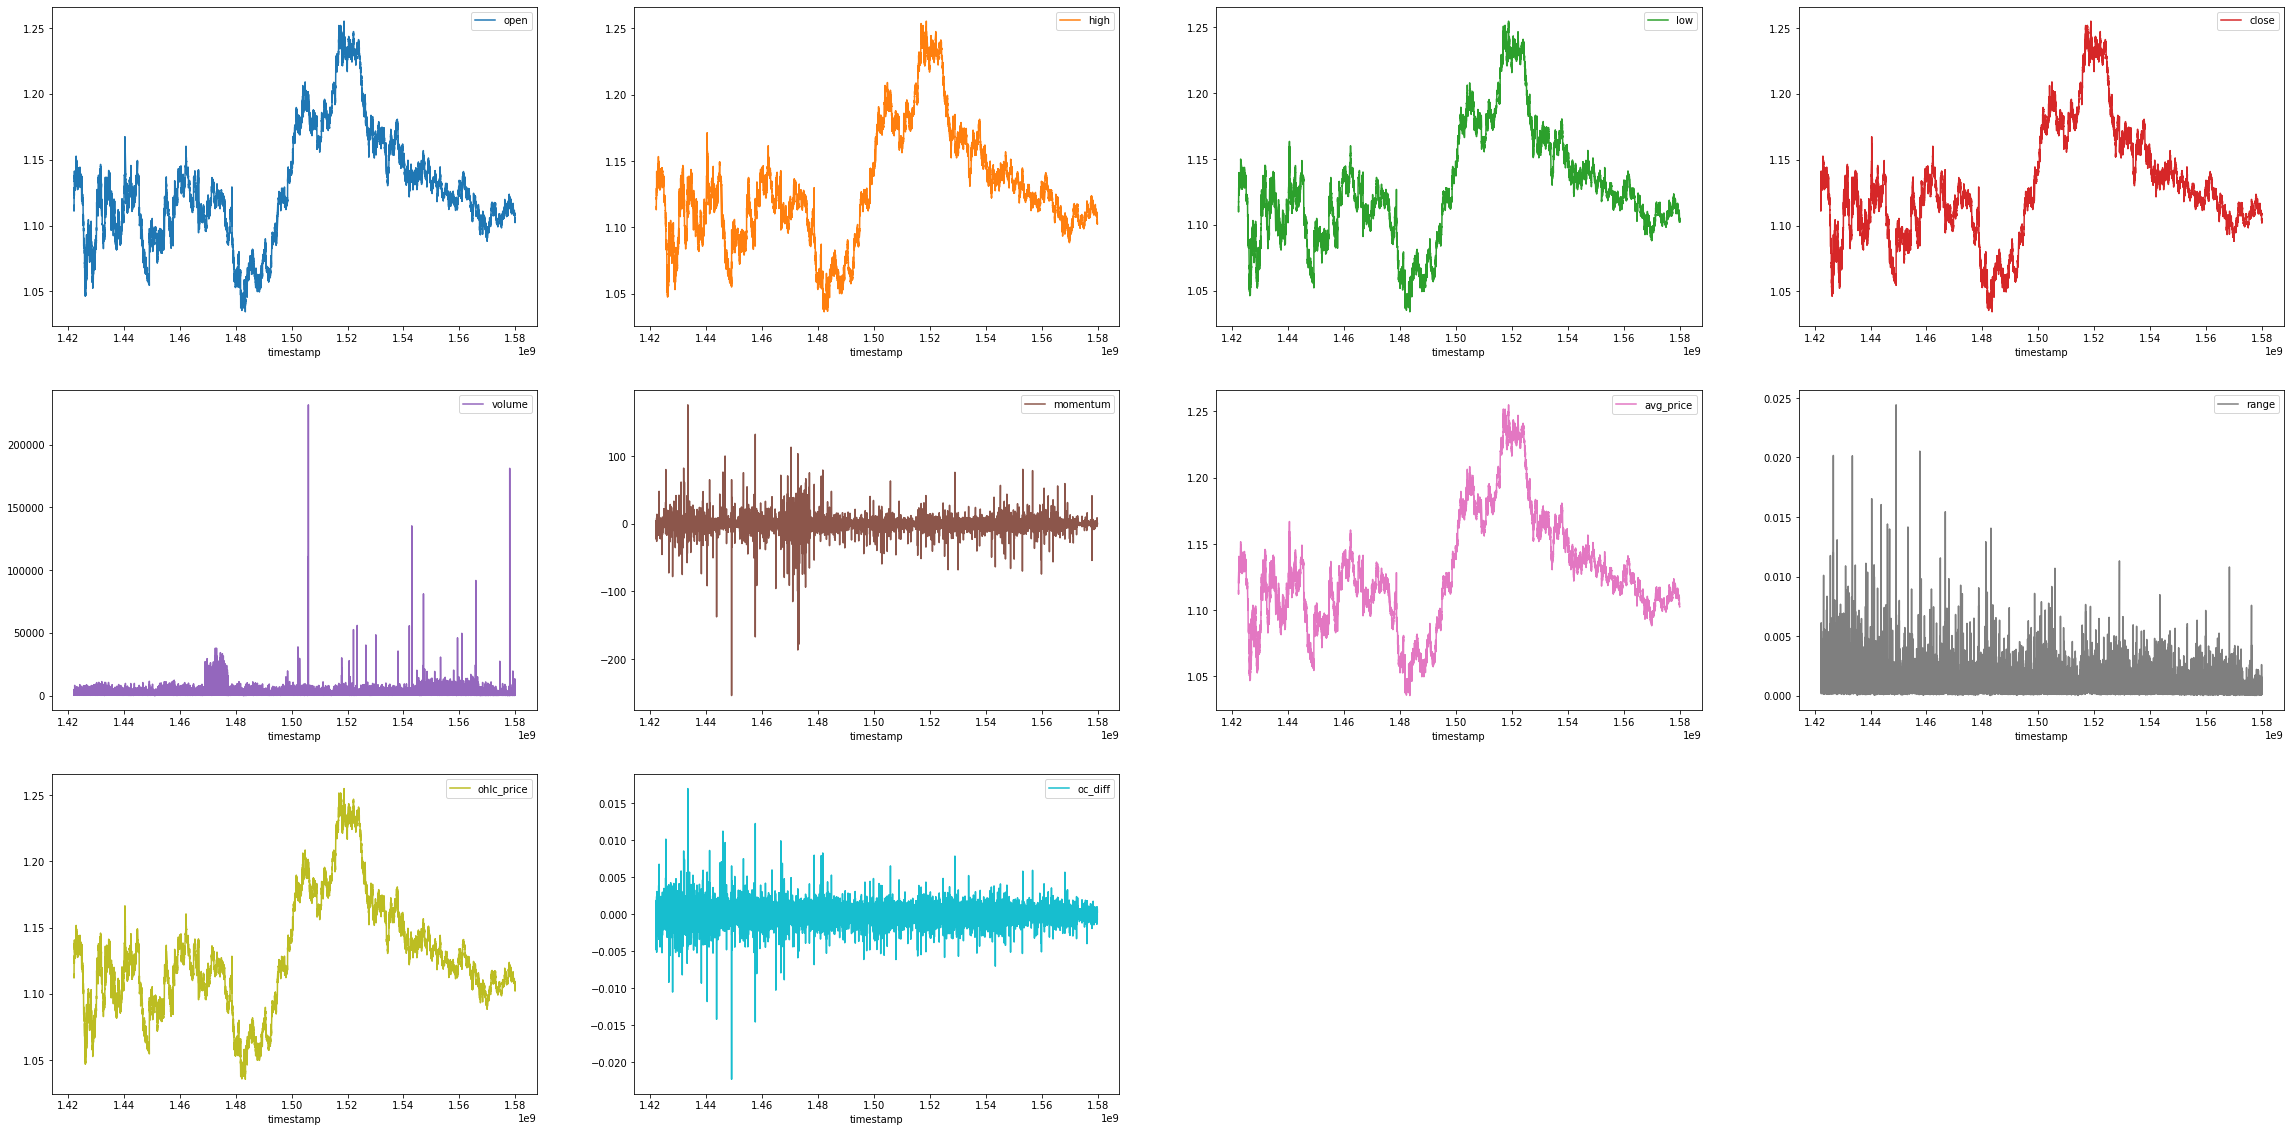

In [155]:

df.plot(subplots=True, layout=(3, 4), figsize=(40, 20), sharex=False);

In [156]:
shift=4 # 1 hour shift
df["future"]=df["close"].shift(-shift)
df.dropna(inplace=True)
df["return"]= df["close"]-df["future"]
display(df.tail(10))

,open,high,low,close,volume,momentum,avg_price,range,ohlc_price,oc_diff,future,return
timestamp,,,,,,,,,,,,
1.579891e+09,1.10280,1.10296,1.10274,1.10275,807.959999,0.040398,1.102850,0.00022,1.102813,0.00005,1.10327,-0.00052
1.579892e+09,1.10277,1.10289,1.10274,1.10279,593.229999,-0.011865,1.102815,0.00015,1.102798,-0.00002,1.10296,-0.00017
1.579892e+09,1.10279,1.10294,1.10274,1.10294,640.620000,-0.096093,1.102840,0.00020,1.102853,-0.00015,1.10285,0.00009
1.579893e+09,1.10294,1.10308,1.10290,1.10304,1044.720000,-0.104472,1.102990,0.00018,1.102990,-0.00010,1.10266,0.00038
1.579894e+09,1.10306,1.10327,1.10296,1.10327,586.119998,-0.123085,1.103115,0.00031,1.103140,-0.00021,1.10264,0.00063
1.579895e+09,1.10327,1.10329,1.10296,1.10296,1083.250002,0.335808,1.103125,0.00033,1.103120,0.00031,1.10277,0.00019
1.579896e+09,1.10295,1.10301,1.10280,1.10285,1218.389999,0.121839,1.102905,0.00021,1.102903,0.00010,1.10286,-0.00001
1.579897e+09,1.10285,1.10287,1.10257,1.10266,843.669992,0.160297,1.102720,0.00030,1.102738,0.00019,1.10274,-0.00008
1.579898e+09,1.10265,1.10277,1.10260,1.10264,486.379998,0.004864,1.102685,0.00017,1.102665,0.00001,1.10250,0.00014


In [157]:
df.drop("future", 1, inplace=True)
# df["target"]= df["return"].shift(shift)
df['target'] = df['return'].apply(lambda x: 1 if x>0.0 else 0)

display(df.tail(15))

,open,high,low,close,volume,momentum,avg_price,range,ohlc_price,oc_diff,return,target
timestamp,,,,,,,,,,,,
1.579886e+09,1.10240,1.10271,1.10220,1.10264,1249.489996,-0.299878,1.102455,0.00051,1.102488,-0.00024,-0.00016,0
1.579887e+09,1.10265,1.10268,1.10239,1.10241,822.599998,0.197424,1.102535,0.00029,1.102532,0.00024,-0.00034,0
1.579888e+09,1.10241,1.10277,1.10241,1.10271,1178.619995,-0.353586,1.102590,0.00036,1.102575,-0.00030,-0.00008,0
1.579889e+09,1.10273,1.10292,1.10262,1.10277,955.270002,-0.038211,1.102770,0.00030,1.102760,-0.00004,-0.00017,0
1.579890e+09,1.10276,1.10286,1.10263,1.10280,878.960001,-0.035158,1.102745,0.00023,1.102763,-0.00004,-0.00024,0
1.579891e+09,1.10280,1.10296,1.10274,1.10275,807.959999,0.040398,1.102850,0.00022,1.102813,0.00005,-0.00052,0
1.579892e+09,1.10277,1.10289,1.10274,1.10279,593.229999,-0.011865,1.102815,0.00015,1.102798,-0.00002,-0.00017,0
1.579892e+09,1.10279,1.10294,1.10274,1.10294,640.620000,-0.096093,1.102840,0.00020,1.102853,-0.00015,0.00009,1
1.579893e+09,1.10294,1.10308,1.10290,1.10304,1044.720000,-0.104472,1.102990,0.00018,1.102990,-0.00010,0.00038,1


In [158]:
times=sorted(df.index.values)
last_10pct=times[-int(0.1*len(times))]
print(last_10pct, datetime.datetime.fromtimestamp(last_10pct))

1564047000.0 2019-07-25 11:30:00


In [159]:
validation_df=df[(df.index >= last_10pct)]
df=df[(df.index < last_10pct)]
validation_df.head()

,open,high,low,close,volume,momentum,avg_price,range,ohlc_price,oc_diff,return,target
timestamp,,,,,,,,,,,,
1.564047e+09,1.11289,1.11292,1.11252,1.11273,3264.270001,0.522283,1.112720,0.00040,1.112765,0.00016,-0.00148,0
1.564048e+09,1.11273,1.11291,1.11268,1.11285,2916.299988,-0.349956,1.112795,0.00023,1.112792,-0.00012,-0.00112,0
1.564049e+09,1.11286,1.11332,1.11285,1.11332,3141.899999,-1.445274,1.113085,0.00047,1.113088,-0.00046,-0.00065,0
1.564050e+09,1.11330,1.11486,1.11328,1.11444,5185.800001,-5.911812,1.114070,0.00158,1.113970,-0.00114,0.00009,1
1.564051e+09,1.11444,1.11461,1.11382,1.11421,4030.740006,0.927070,1.114215,0.00079,1.114270,0.00023,0.00025,1


In [160]:
df.tail()

,open,high,low,close,volume,momentum,avg_price,range,ohlc_price,oc_diff,return,target
timestamp,,,,,,,,,,,,
1.564042e+09,1.11297,1.11321,1.11285,1.11319,3181.209996,-0.699866,1.113030,0.00036,1.113055,-0.00022,0.00030,1
1.564043e+09,1.11319,1.11335,1.11309,1.11327,2956.600000,-0.236528,1.113220,0.00026,1.113225,-0.00008,0.00054,1
1.564044e+09,1.11327,1.11340,1.11289,1.11289,3798.990003,1.443616,1.113145,0.00051,1.113112,0.00038,0.00004,1
1.564045e+09,1.11289,1.11304,1.11272,1.11289,3275.100001,0.000000,1.112880,0.00032,1.112885,0.00000,-0.00043,0
1.564046e+09,1.11288,1.11297,1.11276,1.11289,2667.959996,-0.026680,1.112865,0.00021,1.112875,-0.00001,-0.00155,0


In [161]:
# plt.subplot(1,2,1)
# plt.plot(df.index, df["volume"])
# # df.plot.line(y="volume")
# plt.subplot(1,2,2)
# plt.plot(df.index, df["open"])

In [162]:
def preprocess_df(df):
    df.dropna(inplace=True)
    for col in df.columns:
        if col != "target": 
            df[col] = df[col].pct_change()
            print(col, np.amax(df[col]), np.amin(df[col]))
            # return
            df[col]=minmax_scale(df[col])
            
    df.dropna(inplace=True)  # cleanup again... jic.

    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in df.values:  # iterate over the values
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

    random.shuffle(sequential_data)  # shuffle for good measure.

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X), y  # return X and y...and make X a numpy array!

In [163]:
data=preprocess_df(df)
# print(data.head())

open 0.020906184668172845 -0.015047733967420096
high 0.018794319606338927 -0.014873281786941472
low 0.015708125665005124 -0.015064208837788917
close 0.020906184668172845 -0.015381858902575707
volume 1060.858824299695 -0.9974792908432802
momentum inf -inf


ValueError: Input contains infinity or a value too large for dtype('float64').